In [1]:
import pandas as pd
import os
from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

This data was provided by Transport for NSW. It is the train turnstile "validation" data from 2013 to June 2016.

It includes:
* Date: The date of the reading. If the reading is early in the morning the date is the prior day. This is done so all trips between 5pm and 5am are considered the same date.
* Time: The timeperiod the reading was taken. This is in the format "17 to 18" and is supposed to range from "17 to 18" to "26 to 27" where
 * "17 to 18" means 5pm - 6pm of the current date
 * "25 to 26" means 1pm-2pm the next day
* Line: The train line 
* Station: The tran station
* Exit:    The number of people exiting in that hour
* Entry:   The number of people entering in that hour
* Night:   We added name of the day for the date of the reading, e.g., Friday.

We found that Time also included "0 to 1" and "1 to 2", whic we assume means 1am of the current date. These are rows are corrected so the date is the prior day and the Time is "24 to 25" or "25 to 26"

# Import and clean data

Read in the 4 years of zipped CSV data as a single dataframe. Convert Source, Line, Station and Times to categoricals to save space and speed processing.

In [2]:
DIR='TrainValidationData/'
df = pd.concat([pd.read_csv(DIR+file, names=['Source', 'Line','Time', 'Station', 'Entry', 'Exit', 'Date'], 
                             na_values=['', ' '], converters={'Entry':int, 'Exit':int}, header=0) 
                 for file in os.listdir(DIR)])

df.Source = df.Source.astype('category')
df.Line = df.Line.astype('category')

stations = ['Kings Cross Station', 'Newtown Station', 'Parramatta Station',
'Town Hall Station', 'Central Station', 'Circular Quay Station', 'Martin Place Station', 'Museum Station', 'St James Station', 
'Bondi Junction Station', 'North Sydney Station']
df.Station = df.Station.astype('category', ordered=True, categories=stations)

Calculate Datetime as a time stamp using Date + the hour of the Time

In [3]:
BANDS = ["{} to {}".format(i,i+1) for i in range(0,27)]
df.Time = df.Time.astype('category', ordered=True,  categories=BANDS)

df.Date = pd.to_datetime(df.Date, format='%d/%m/%Y %H:%M')
df['Datetime'] = df.Date + pd.to_timedelta(df.Time.cat.codes, unit='h')

Remove items before Friday 5pm or after Monday 5pm as these are not part of our study.

In [4]:
df['Night'] = df.Date.dt.weekday_name.astype('category')
df = df[~((df.Time < '17 to 18') &  (df.Night == 'Friday'))]
df = df[~((df.Time >= '17 to 18') &  (df.Night == 'Monday'))]

Recompute Date so all observations between 5pm and 5am have the same date. Create Night as the name of that day, e.g., Friday

In [5]:
df.Date = pd.to_datetime((df['Datetime'] - timedelta(hours = 6)).dt.date)

df['Night'] = df.Date.dt.weekday_name.astype('category', ordered=True, 
                                             categories=['Friday', 'Saturday', 'Sunday'])

hours = ['05PM', '06PM', '07PM', '08PM', '09PM', '10PM', '11PM', '12AM','01AM', '02AM']
df.Time = (df.Datetime.dt.strftime('%I%p').
                           astype('category', ordered=True, categories=hours))

Since there are multiple lines for the same date/station/Time, aggegrate to create one per "observation"

In [6]:
df = df.groupby(['Station','Night', 'Time','Date'], as_index=False).agg({'Entry':'sum', 'Exit':'sum'})
print(len(df), "observations from", df.Date.min(), "to", df.Date.max())

49445 observations from 2013-02-01 00:00:00 to 2016-07-31 00:00:00


In [51]:
df.to_pickle("TrainValidationData/df.pkl")

# Check and Clean Data

Our first check is for whole days that are missing for a station. 

In [7]:
xx = df.pivot_table(index = 'Date', columns = ['Station'], values='Exit', aggfunc=sum)
print("Number of days", len(xx))
for station in xx.columns:
    print("{:>22}: {:}".format(station, xx[station].isnull().sum()))

Number of days 549
   Kings Cross Station: 14
       Newtown Station: 58
    Parramatta Station: 6
     Town Hall Station: 0
       Central Station: 2
 Circular Quay Station: 13
  Martin Place Station: 10
        Museum Station: 16
      St James Station: 17
Bondi Junction Station: 11
  North Sydney Station: 12


Most stations are missing less that 2%, however Newtown is missing 10% and so we need to use this data with caution

In [8]:
for dt in xx[xx['Newtown Station'].isnull()].index:
    print(dt, dt.weekday_name)

2013-02-02 00:00:00 Saturday
2013-02-03 00:00:00 Sunday
2013-02-09 00:00:00 Saturday
2013-02-10 00:00:00 Sunday
2013-02-16 00:00:00 Saturday
2013-02-17 00:00:00 Sunday
2013-02-23 00:00:00 Saturday
2013-02-24 00:00:00 Sunday
2013-03-02 00:00:00 Saturday
2013-03-09 00:00:00 Saturday
2013-03-10 00:00:00 Sunday
2013-03-16 00:00:00 Saturday
2013-03-17 00:00:00 Sunday
2013-03-23 00:00:00 Saturday
2013-03-24 00:00:00 Sunday
2013-03-29 00:00:00 Friday
2013-03-30 00:00:00 Saturday
2013-03-31 00:00:00 Sunday
2013-04-06 00:00:00 Saturday
2013-04-07 00:00:00 Sunday
2013-04-13 00:00:00 Saturday
2013-04-14 00:00:00 Sunday
2013-04-20 00:00:00 Saturday
2013-04-21 00:00:00 Sunday
2013-04-27 00:00:00 Saturday
2013-04-28 00:00:00 Sunday
2013-05-04 00:00:00 Saturday
2013-05-05 00:00:00 Sunday
2013-05-11 00:00:00 Saturday
2013-05-12 00:00:00 Sunday
2013-05-18 00:00:00 Saturday
2013-06-22 00:00:00 Saturday
2013-06-23 00:00:00 Sunday
2013-06-29 00:00:00 Saturday
2013-06-30 00:00:00 Sunday
2013-07-13 00:00:00

Looking at this data, these are consecuative Sat & Sun days from 2013-02-02 to 2013-11-03. The most likely explaination is before the lockout laws, Newtown gates were open on the weekends and people did not use the turnstiles to pass out. Around the time of the lockout laws this patter changes

## Find Outliers

Looking at histograms of Kings Cross and Parramatta at 5pm, 6pm and 7pm on Saturday shows the Exit volumes are approximately symetrical distributed with some outliers. 

In [56]:
df = pd.read_pickle("TrainValidationData/df.pkl")

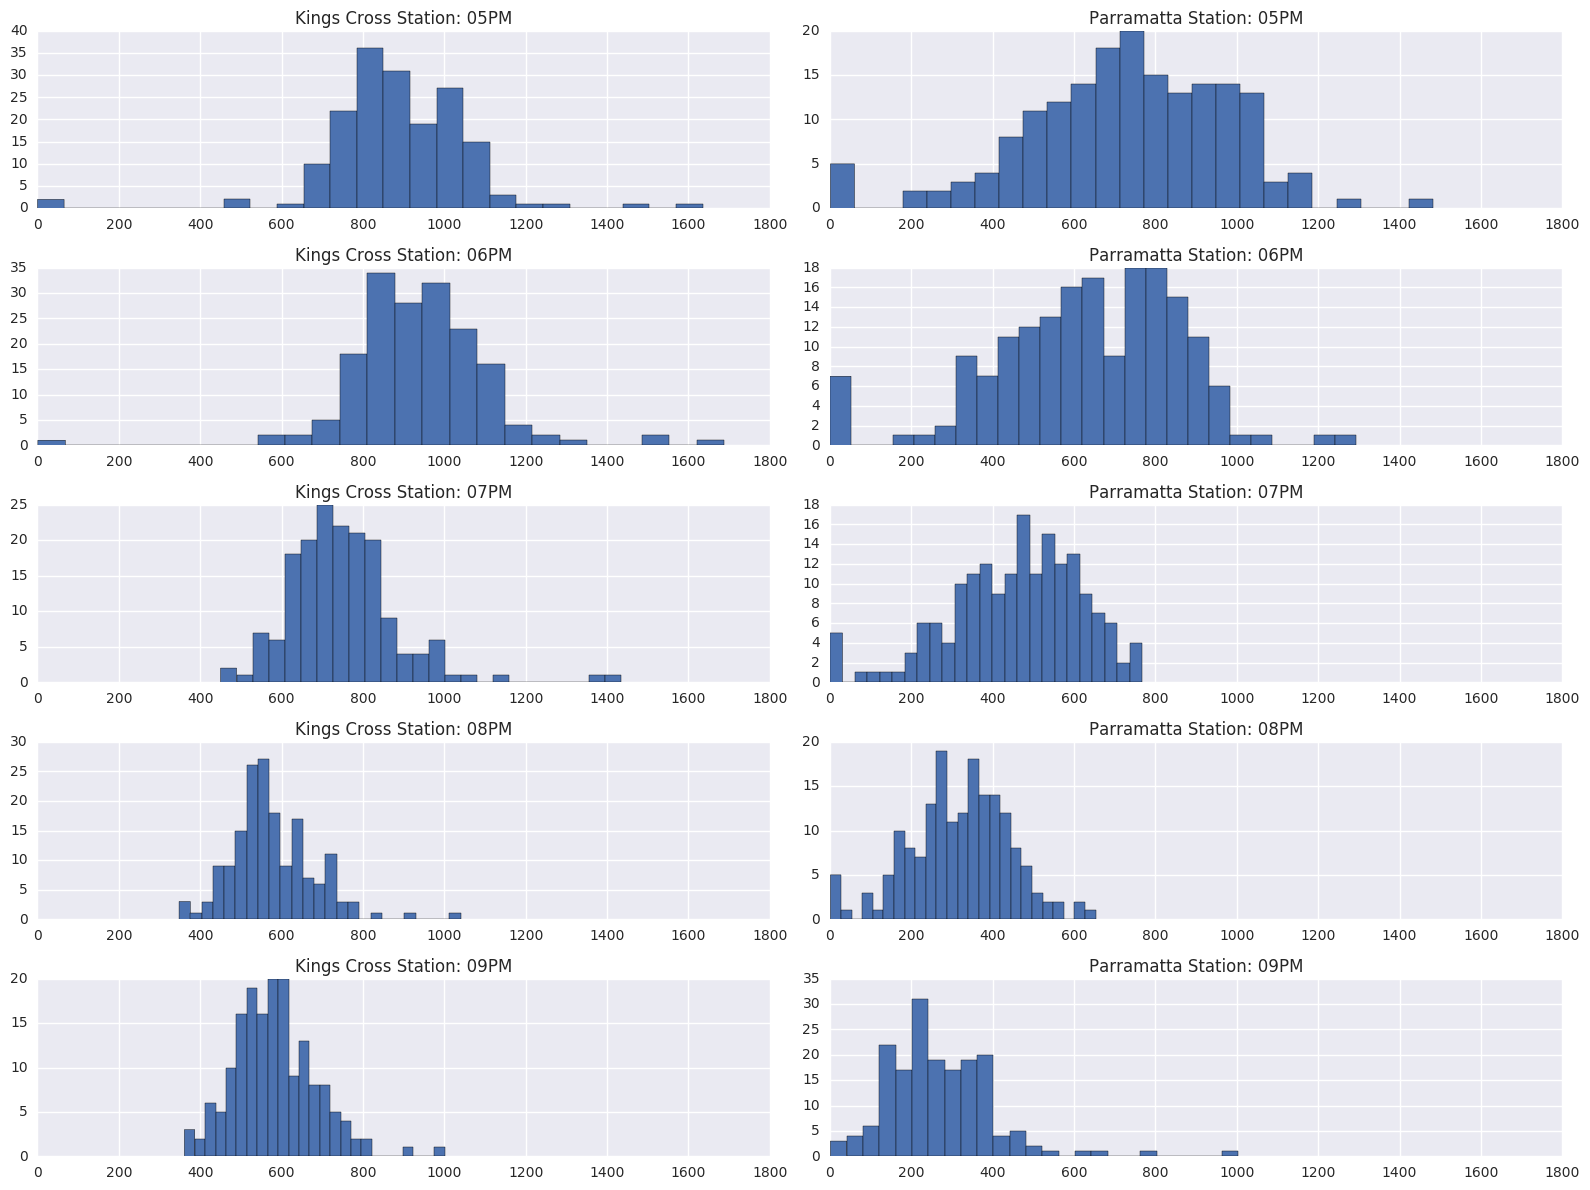

In [57]:
fig, grid = plt.subplots(nrows=5, ncols=2, sharex=False, sharey=False, squeeze=True, figsize=(16, 12))
for time, axes in zip(["05PM", "06PM", "07PM", "08PM", "09PM"], grid):
    for station, ax in zip(["Kings Cross Station", "Parramatta Station"], axes):
        ts = df.query('Station == @station and Night == "Saturday" and Time == @time')
        ax.hist(ts.Exit, bins=25)
        ax.set_title(station + ": " + time)
        ax.set_xlim(0, 1800)
plt.tight_layout()

Since these is approximately symetric can use a [Robust Zscore](http://eurekastatistics.com/using-the-median-absolute-deviation-to-find-outliers/) on each to identify the outliers and replace them with NaN

In [90]:
import numpy as np
from statsmodels import robust


def outlier(df, window=13, sd=6, on=None):
    ''' Replace outliers based on a rolling windows with NaN'''

    def outlier_to_NaN(npArray, sd):
        
        x = npArray[len(npArray)//2]
        outlier = abs(x - np.median(npArray))/robust.mad(npArray) > sd

        return (x if (not outlier) else np.NaN)

    if window % 2 == 0:
        raise ValueError('Window must be odd')
        

    df_clean = (df.rolling(window=window, center=True, on=on).
                 apply(lambda x: outlier_to_NaN(x, sd=sd)))
    
    #add back the items at the start/end that get set to NaN due to the rolling window
    df_clean[:window//2] =  df[:window//2]
    df_clean[-window//2:] = df[-window//2:]

    return df_clean

After some experimentation we settled on a window of 15 and sd of 4 to eliminate outliers. Note that the use of windowing cause the first and last 6 items of each timeseries to be NaN

In [64]:
df_clean = (df.groupby(['Station', 'Night', 'Time'], as_index=False).
                   apply(lambda x: outlier(x, window=15, sd=4, on='Date')))

Checking the length and start/end dates match gives a level of confidence in the processes

In [65]:
assert len(df) == len(df_clean), "Length of cleaned data is incorrect"
assert df.Date.min() == df_clean.Date.min(), "Start dates don't match" 
assert df.Date.max() == df_clean.Date.max(), "End dates don't match" 

We can visually spot check by plotting the Cleaned Exit data (green) over the top of the Raw data (blue). 

In most places the green line (clean) overwrites the blue (raw) indicating the data is the same. The line is blue where an outlier that has been removed from the cleaned data. 

A quick inspection shows the cleaning processes has worked well.

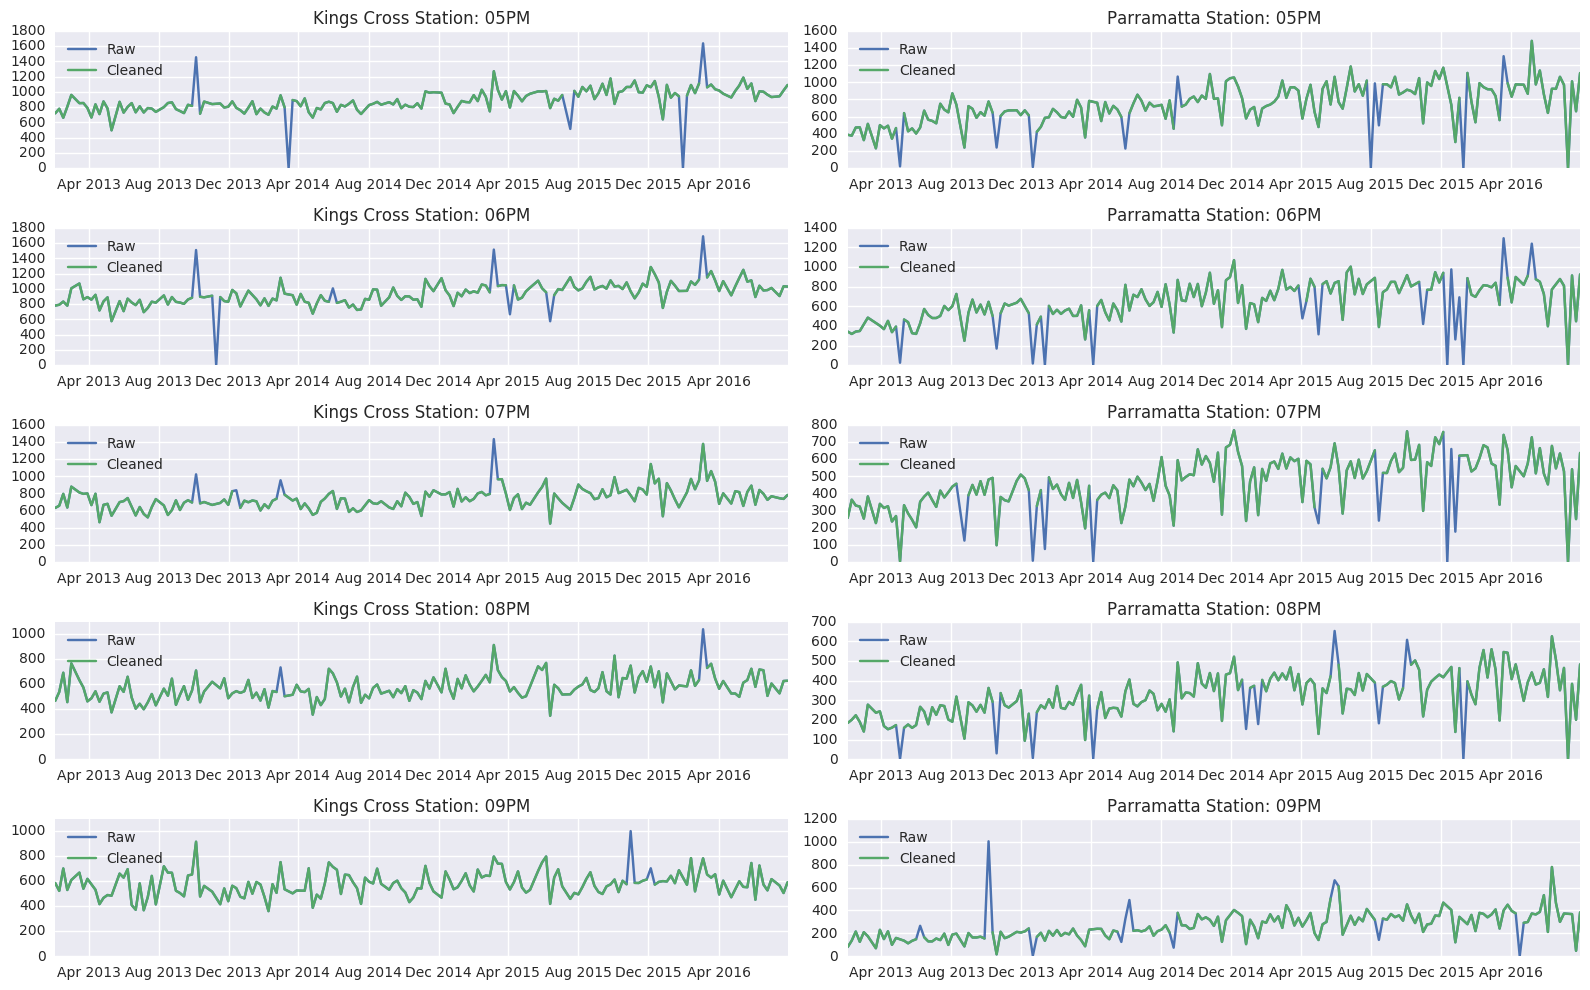

In [66]:
fig, grid = plt.subplots(nrows=5, ncols=2, sharex=False, sharey=False, squeeze=True, figsize=(16, 10))
for time, axes in zip(["05PM", "06PM", "07PM", "08PM", "09PM"], grid):
    for station, ax in zip(["Kings Cross Station", "Parramatta Station"], axes):
        ts = df.query('Station == @station and Night == "Saturday" and Time == @time')
        ax.plot(ts.Date, ts.Exit, label='Raw')
        ts1 = df_clean.query('Station == @station and Night == "Saturday" and Time == @time')
        ax.plot(ts1.Date, ts1.Exit, label='Cleaned')
        ax.legend(loc='upper left')
        ax.set_title(station + ": " + time)
        ax.set_ylim((0,None))

plt.tight_layout()

## Interpolate

Next we fill in the outliers that have been removed.

In [67]:
df_clean = df_clean.groupby(['Station', 'Night', 'Time'], as_index=False).apply(pd.DataFrame.interpolate)

Again we visually spot check and note the green line is filled in at the outliers. Note we are missing the first 6 data points due the the use of a sliding window to calculate the outliers

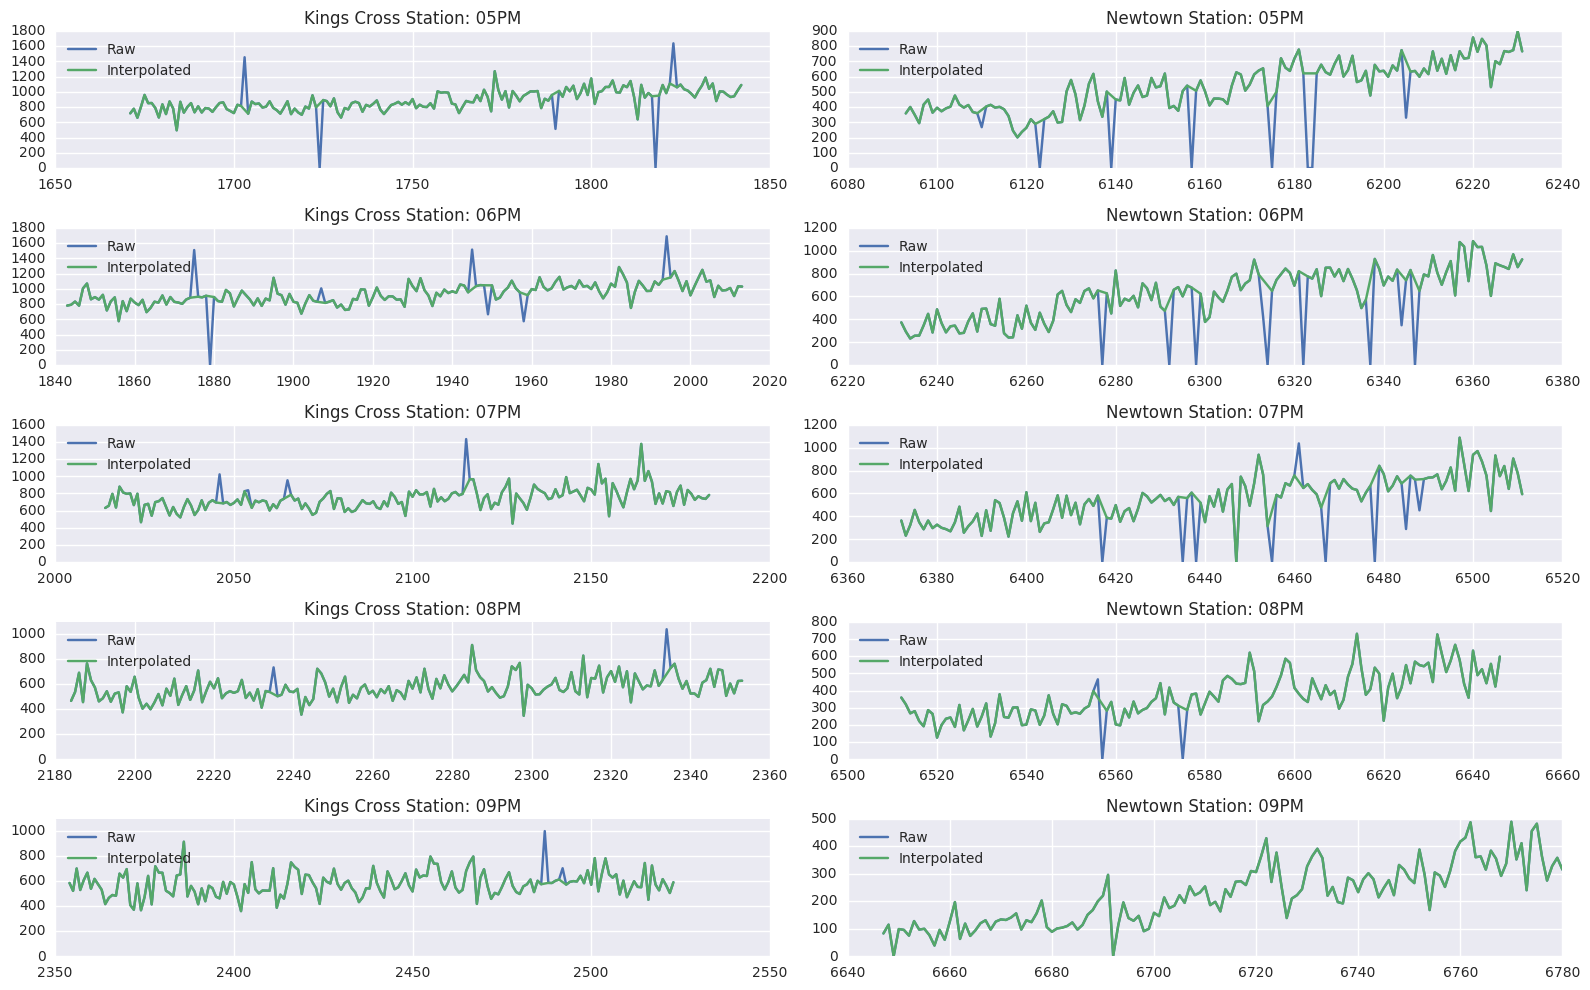

In [68]:
fig, grid = plt.subplots(nrows=5, ncols=2, sharex=False, sharey=False, squeeze=True, figsize=(16, 10))
for time, axes in zip(["05PM", "06PM", "07PM", "08PM", "09PM"], grid):
    for station, ax in zip(["Kings Cross Station", "Newtown Station"], axes):
        ts = df.query('Station == @station and Night == "Saturday" and Time == @time')
        ax.plot(ts.index, ts.Exit, label='Raw')
        ts1 = df_clean.query('Station == @station and Night == "Saturday" and Time == @time')
        ax.plot(ts1.index, ts1.Exit, label='Interpolated')
        ax.legend(loc='upper left')
        ax.set_title(station + ": " + time)
        ax.set_ylim((0,None))
        
plt.tight_layout()

Save the cleaned data for analysis

In [69]:
df_clean.to_pickle("TrainValidationData/df_clean.pkl")

# Explore time/day of week data

In [115]:
df_clean = pd.read_pickle("TrainValidationData/df.pkl")

In [46]:
df_clean['Year'] = df_clean.Date.dt.year
df_clean['Quarter'] = pd.to_datetime(pd.DataFrame({"Year": df_clean.Date.dt.year, "Month": (df_clean.Date.dt.quarter-1)*3+1, "Day":1 }))

The following charts shows Exit volumes per hour, by Night by Station. We note
- The volumes generall decline over time as might be reasonably exptected
- On Friday night, the 5pm and 6pm exit traffic is much higher than on Saturday or Sunday, especially in  Parramata. This might be commuters heading home.
- We need to be cautious about comparing volumes in Newtow to the other station as most of the 2013 data is missing.

In [47]:
stations = ['Kings Cross Station', 'Newtown Station', 'Parramatta Station',
            'Town Hall Station', 'Central Station', 'Circular Quay Station', 
            'Martin Place Station', 'Museum Station', 'St James Station', 
            'Bondi Junction Station', 'North Sydney Station']

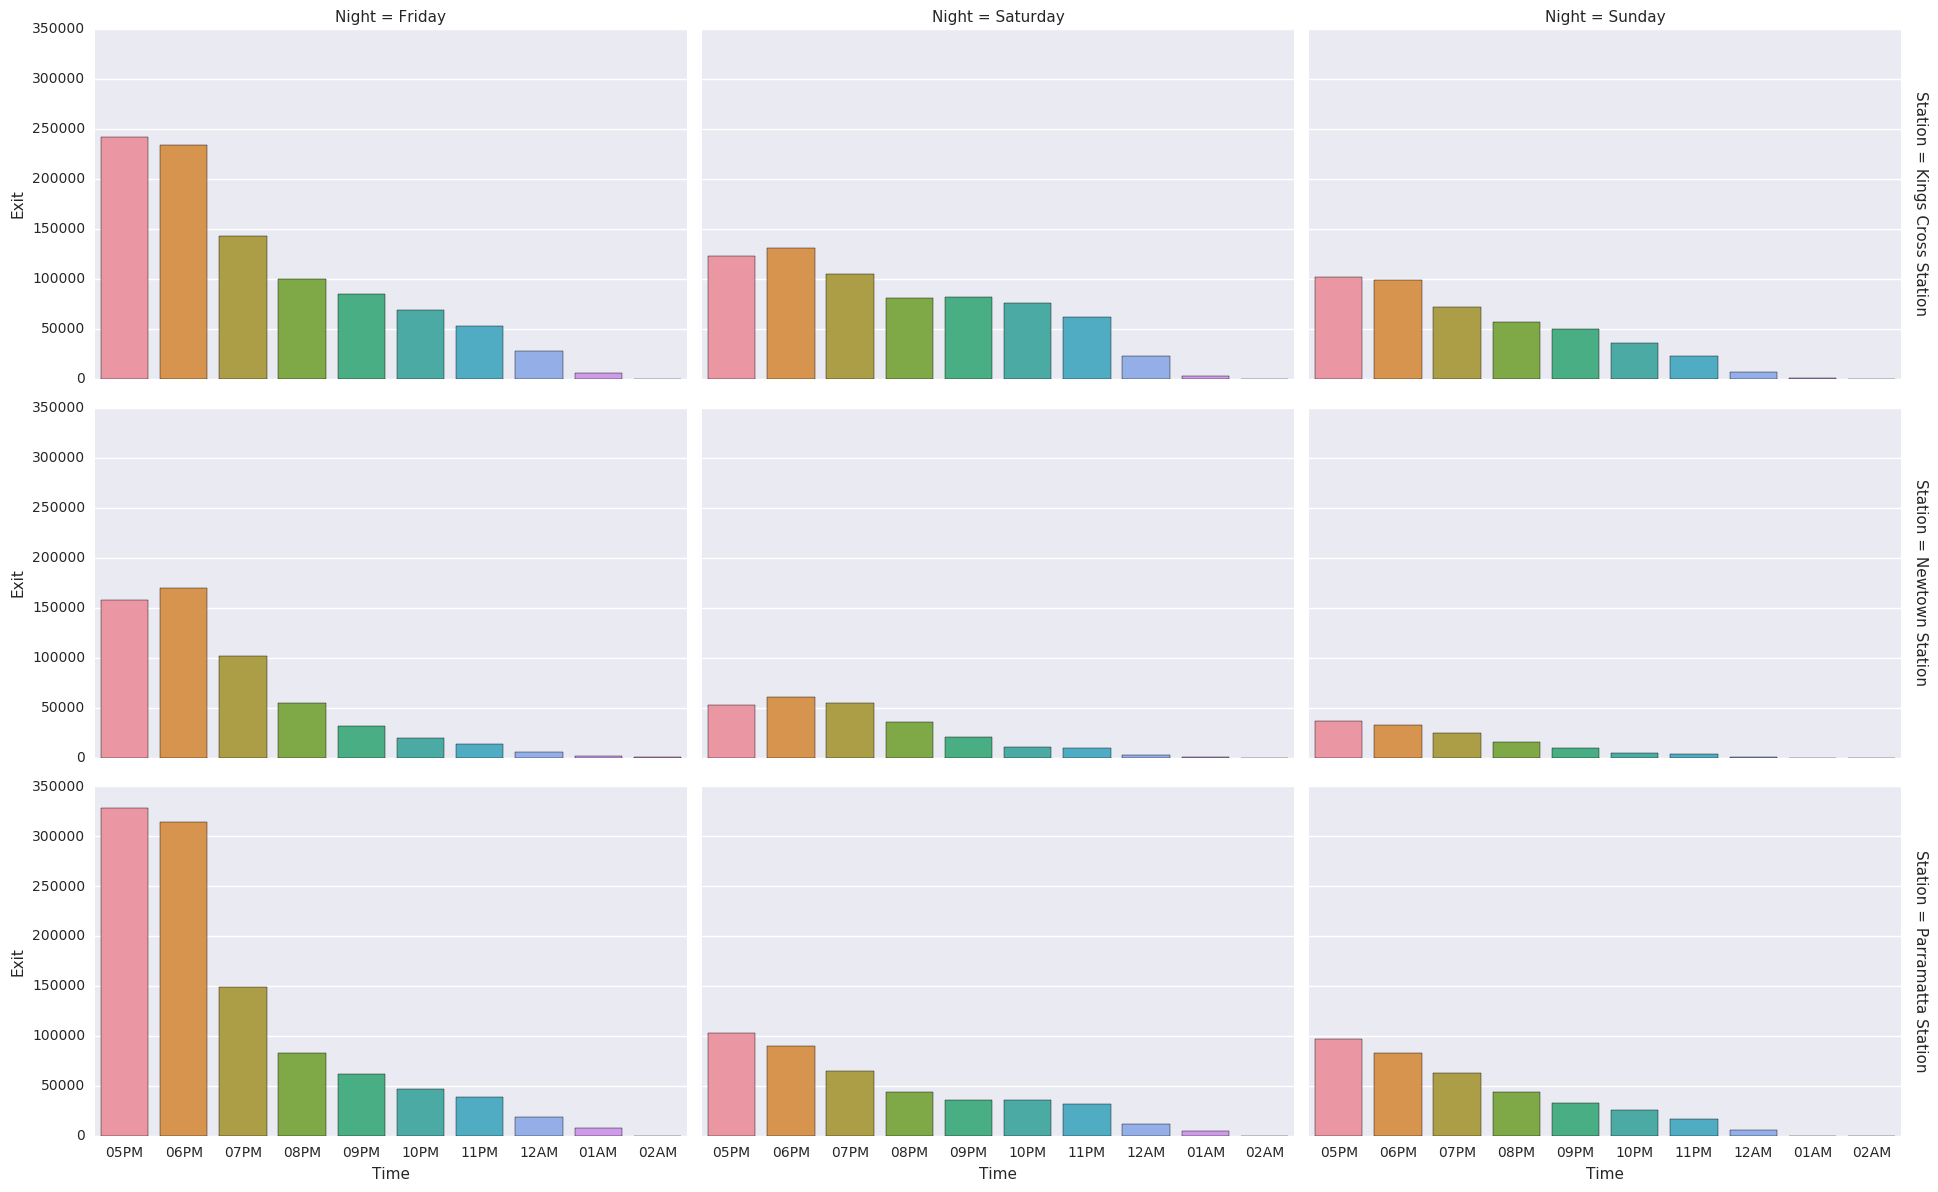

In [48]:
sns.factorplot(data=df_clean.query('Year < 2016'), x='Time', y='Exit', kind="bar", 
               row="Station", row_order=stations[:3], col = 'Night',
               aspect=1.6, ci = None,margin_titles = True, estimator=sum)

Lets look at the Total yearly exit volumes broken by Night by Station. We exclude the 2016 data as this is only for half a year.
- The highter volumes on a Friday are probably due to commuters heading home at 5pm and 6. See charts above. 
- For all stations the volumes increased between 2013 and 2015. Note the Newtown data for 2013 on Saturday and Sunday is much lower than 2014/16 as most of that years data is missing for Newtown.

What is most noticable, is the volume of train exits in Kings cross increased between 2013 and 2016, indicating that the lockout laws did not impact train usage. 

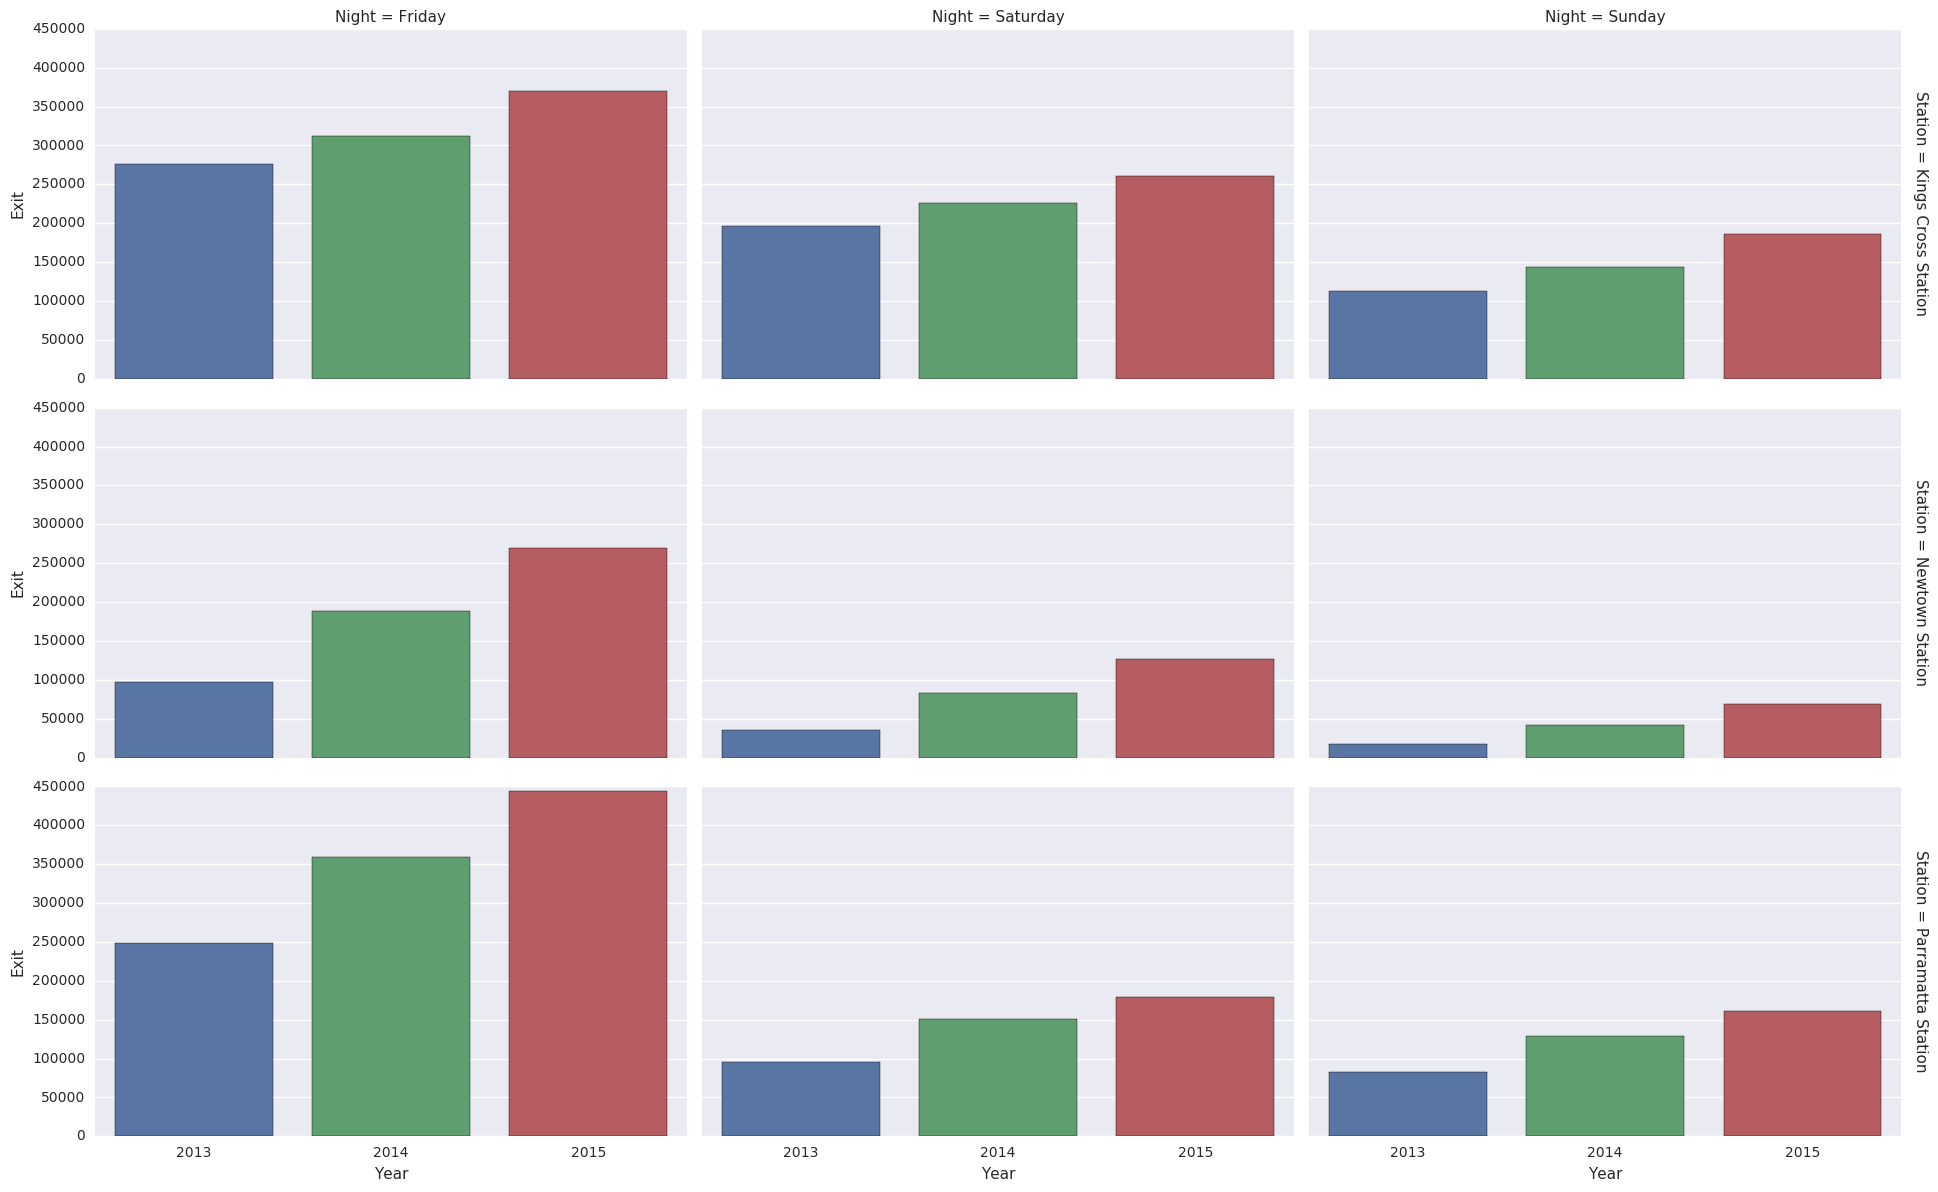

In [49]:
sns.factorplot(data=df_clean.query("Year < 2016"), x='Year', y='Exit', kind="bar", 
               row="Station", row_order=stations[:3], col = 'Night',
               aspect=1.6, ci = None,margin_titles = True, estimator=sum)

Plotting total Exit data from 7pm onwards, by Night by Station shows:
* Kings cross volumes were not impacted by the lockout laws
* Newtown and Parramatta volumes on a Friday ahve increased significantly in the last few years. 

Note Newtown data for Sat/Sun must be interpreted with case due most data for 2013 not being recorded.

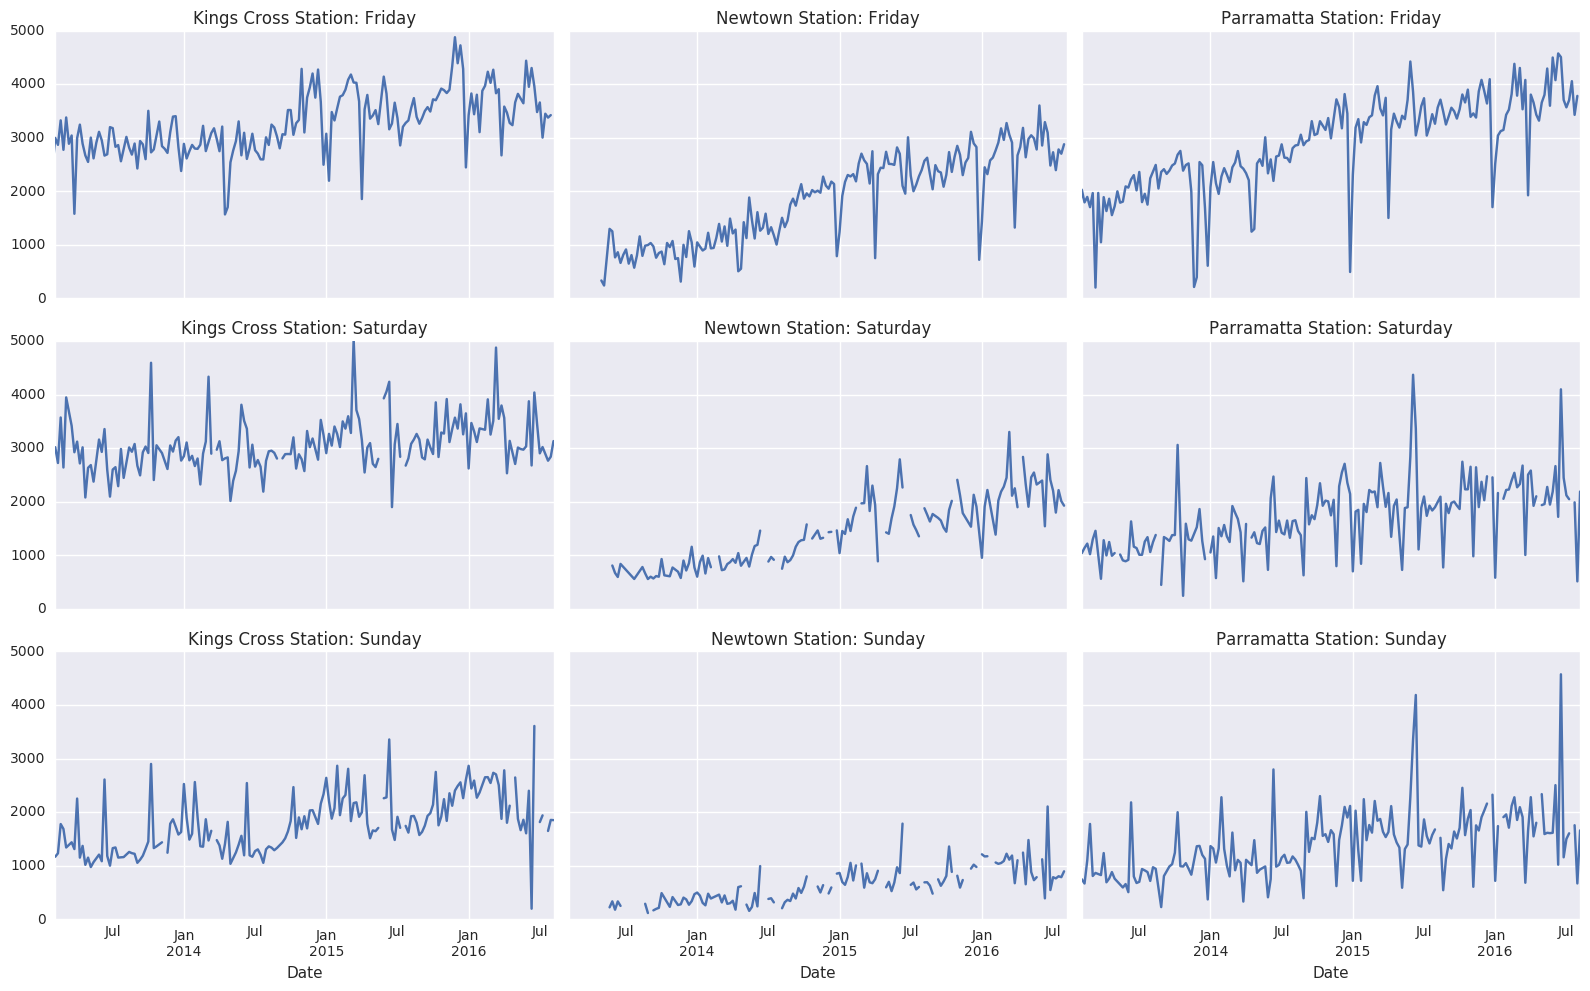

In [173]:
fig, grid = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, squeeze=True, figsize=(16, 10))
for night, axes in zip(['Friday', 'Saturday', 'Sunday'], grid):
    for station, ax in zip(["Kings Cross Station", "Newtown Station", "Parramatta Station"], axes):
        ts = (df_clean[df_clean.Time >= "07PM"].query('Station == @station and Night == @night').
                       groupby('Date')['Exit'].sum())
        ts.where(ts > 100).plot(x='Date', ax=ax)
        ax.set_title(station + ": " + night)
        ax.set_ylim((0,5000))
        
plt.tight_layout()

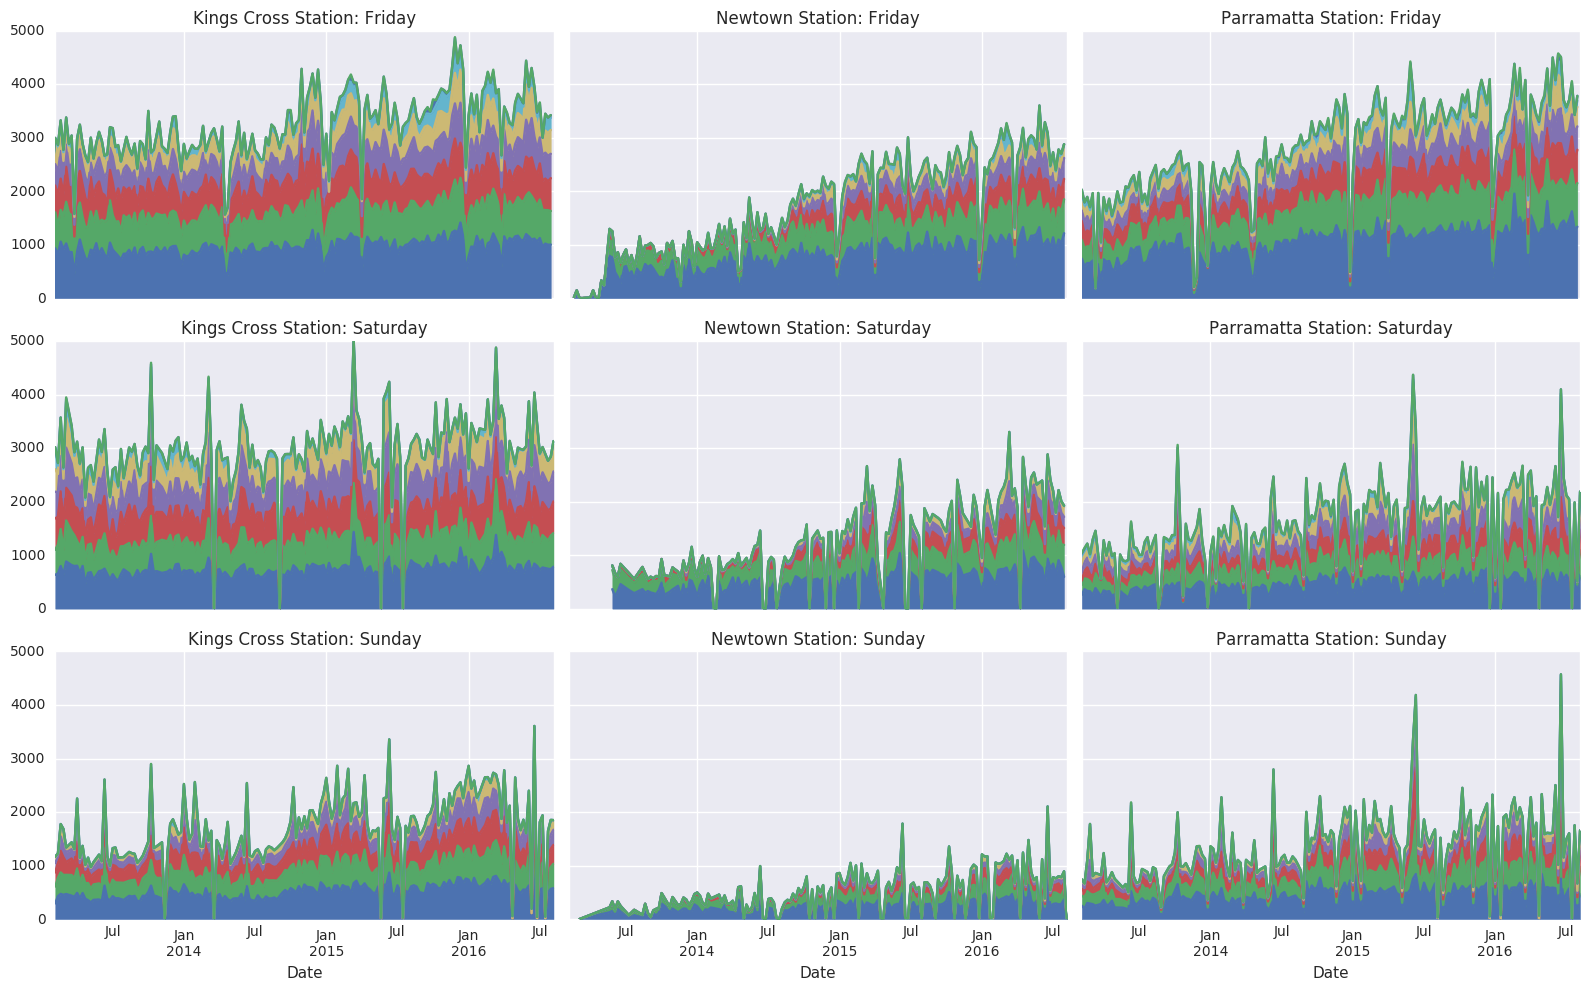

In [171]:
fig, grid = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, squeeze=True, figsize=(16, 10))

for night, axes in zip(['Friday', 'Saturday', 'Sunday'], grid):
    for station, ax in zip(["Kings Cross Station", "Newtown Station", "Parramatta Station"], axes):
        (df_clean[df_clean.Time >= "07PM"].query('Station == @station and Night == @night').
                       pivot('Date', 'Time', 'Exit').plot.area(ax=ax, legend=None))
        ax.set_title(station + ": " + night)
        ax.set_ylim((0,5000))
        
plt.tight_layout()

## Autocorrelation

In [53]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

def tsplot(ts):

    ts.plot(y='Exit', ax = plt.subplot2grid((2,3), (0,0), colspan=3))
    smt.graphics.plot_acf(ts, ax=plt.subplot2grid((2,3), (1,0)))
    smt.graphics.plot_pacf(ts,  ax=plt.subplot2grid((2,3), (1,1)))
    sm.qqplot(ts,  line='s',  ax= plt.subplot2grid((2,3), (1,2)))
    plt.tight_layout()

The autocorrolation plot of the Kings Cross, Saturday Night 7PM+ data indicates minimial seasonal effects

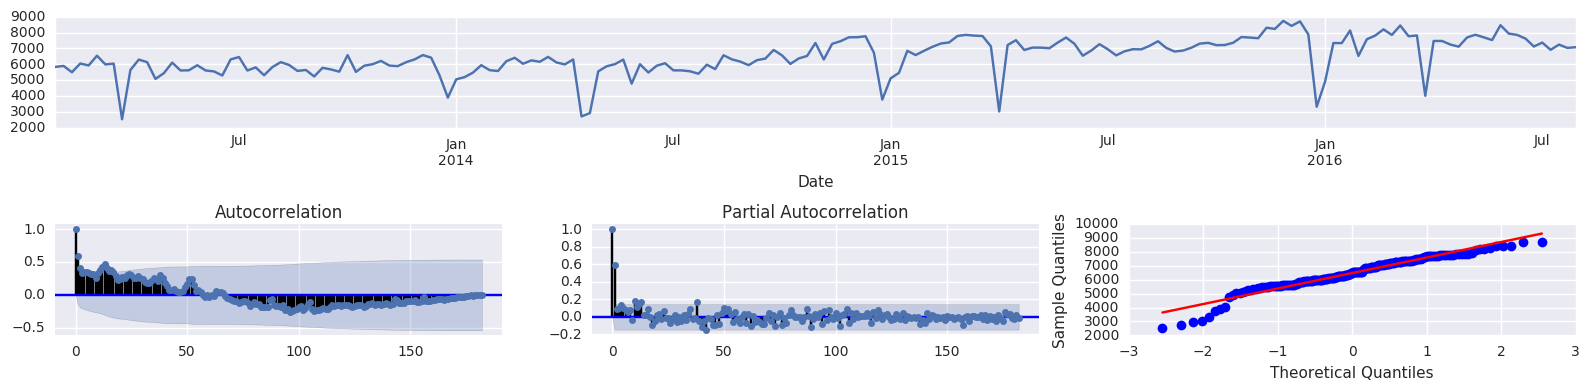

In [128]:
ts = (df_clean.query('Station == "Kings Cross Station" and Night == "Friday"').
          groupby('Date')['Exit', 'Entry'].sum())

plt.figure(figsize=(16,4))
tsplot(ts.Exit)

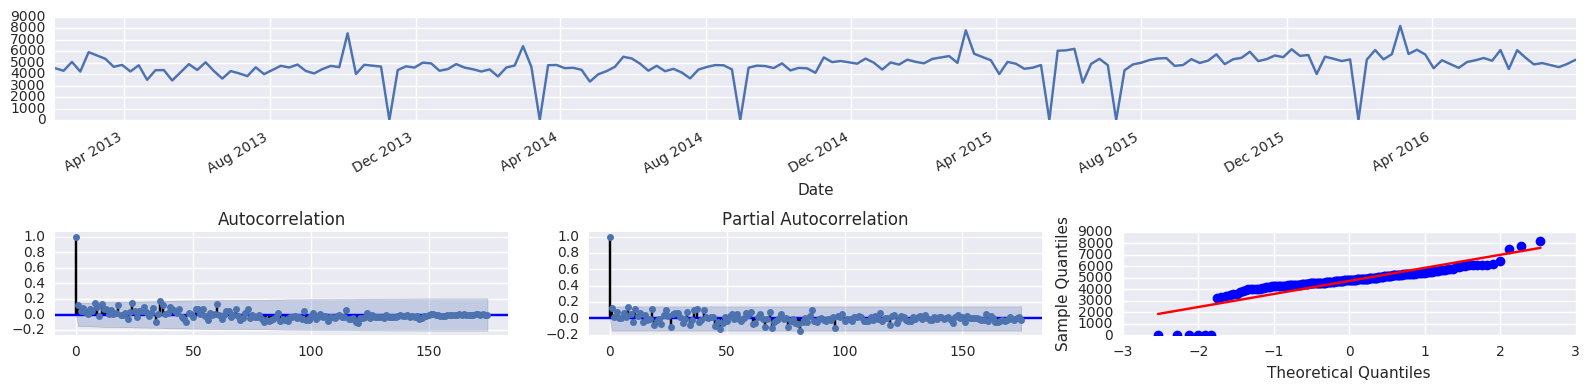

In [123]:
ts = (df_clean.query('Station == "Kings Cross Station" and Night == "Saturday"').
          groupby('Date')['Exit', 'Entry'].sum())

plt.figure(figsize=(16,4))
tsplot(ts.Exit)

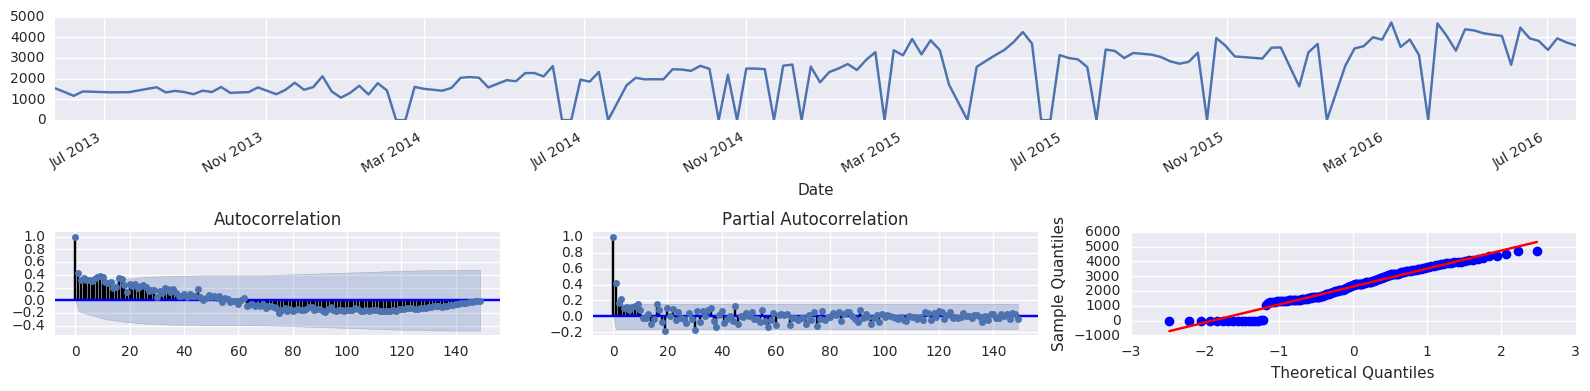

In [124]:
ts = (df_clean.query('Station == "Newtown Station" and Night == "Saturday"').
          groupby('Date')['Exit', 'Entry'].sum())

plt.figure(figsize=(16,4))
tsplot(ts.Exit)

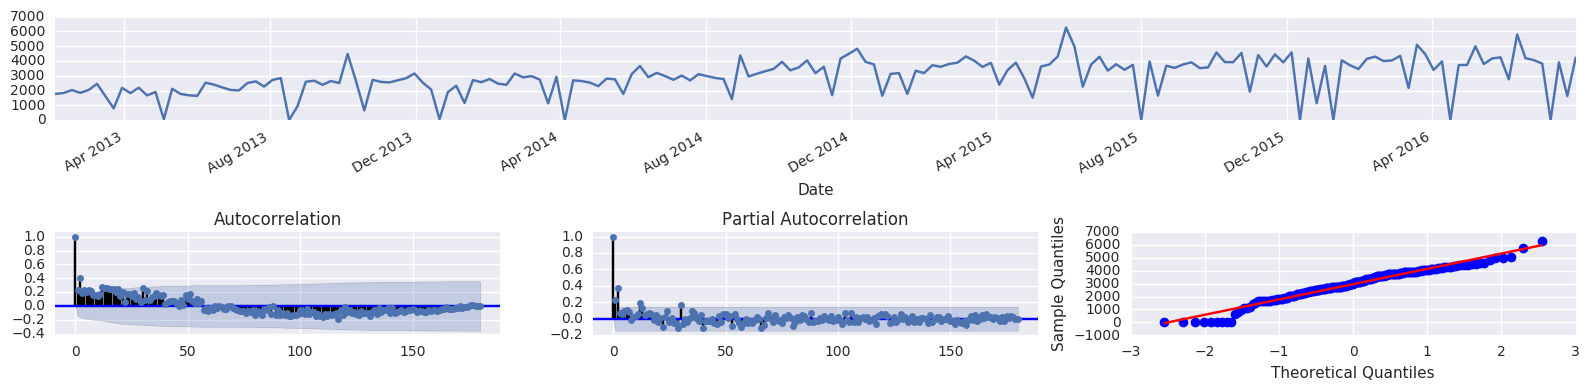

In [127]:
ts = (df_clean.query('Station == "Parramatta Station" and Night == "Saturday"').
          groupby('Date')['Exit', 'Entry'].sum())

plt.figure(figsize=(16,4))
tsplot(ts.Exit)